In [1]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np   
import pandas as pd            
import matplotlib.pyplot as plt  
import scipy.signal                
from IPython import display
              
%matplotlib inline
pykat.init_pykat_plotting(dpi=200)

                                              ..-
    PyKat 1.2.81          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
kat1 = finesse.kat()
kat1.verbose=True
kat1.parse("""

l laser 30 0 n1                          #laser 30W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod eom1 $sb1 0.18 3 pm n2 n3         #modulator PM $sb1 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12
#########################


####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.899 0.1 0 refl pop               #PRM                ---> POP <---

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.999 0.001 0 0 bs1a bs12 bs12tr dump
s b1 0.350 bs12 bs21
bs bs2 0.999 0.001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    
###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.3 n12 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 0 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################


cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3


##### attr for TM ######
attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM
attr PRM xbeta 0            # misalgnment PRM
attr ETM xbeta 0            # misalgnment ETM
attr ITM xbeta 0            # misalgnment ITM
######################


trace 2 
phase 2

const sb1 55.556M
const sb2 111.112M
const sb3 166.668M


#

""")

--------------------------------------------------------------
Running kat - Started at 2022-11-27 03:33:26.215447


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 10.5644 seconds

--- Output info ---

Run date and time: 2022-11-27 03:33:26.215447
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 10 140 8000']
circ_arm : min = 3.196495332384110e+02 max = 2.583401090408810e+05
circ_prc : min = 8.382629740615271e-01 max = 6.763210033198450e+02
refl     : min = 8.539145707203319e+00 max = 2.994048226663380e+01
trans    : min = 3.196623197312000e-03 max = 2.583504430586030e+00


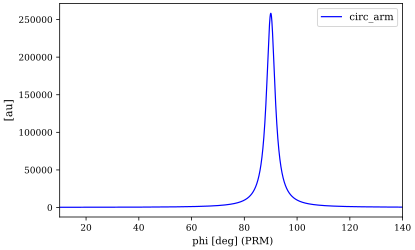

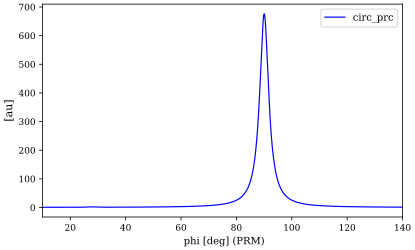

max power arm 258340.109040881
array number [[4925]]
PRM tuning for max power in arm and prc [[90.03125]]


In [3]:
#### DC PDs ##########

kat_dc = kat1.deepcopy()
kat_dc.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis PRM phi lin 10 140 8000


""")

out_dc = kat_dc.run()
out_dc.info()
out_dc.plot(['circ_arm'])
out_dc.plot(['circ_prc'])
print("max power arm",max(out_dc['circ_arm']))
print("array number",np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm'])))
print("PRM tuning for max power in arm and prc",out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))])


### SET PRM phi ###
kat1.PRM.phi = out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))]

--------------------------------------------------------------
Running kat - Started at 2022-11-27 03:33:37.746757


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 10.9273 seconds

--- Output info ---

Run date and time: 2022-11-27 03:33:37.747262
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis ETM phi lin -0.05 0.05 8000']
circ_arm : min = 2.537830186625860e+03 max = 2.583401090408810e+05
circ_prc : min = 2.384936168992730e+01 max = 6.763210033198450e+02
refl     : min = 8.539145707203319e+00 max = 2.967013511233790e+01
trans    : min = 2.537931703894020e-02 max = 2.583504430586030e+00


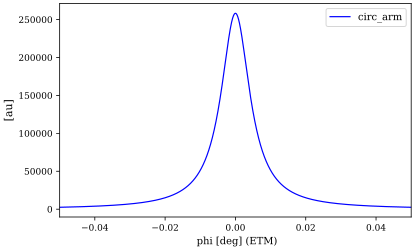

max power arm 258340.109040881
half max power arm 129170.0545204405
array number max [[4000]]
Nearest element to the given values is : array number half 129300.546500276
array number max [[3602]]
detuning left [[-0.004975]]


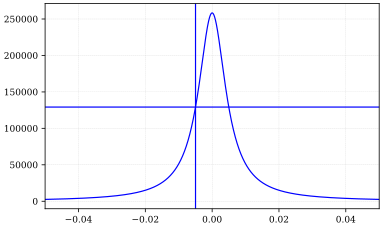

In [4]:
kat_dt = kat1.deepcopy()
kat_dt.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis ETM phi lin -0.05 0.05 8000


""")
out_dt = kat_dt.run()
out_dt.info()
out_dt.plot(['circ_arm'])
#out_dt.plot(['circ_prc'])

print("max power arm",max(out_dt['circ_arm']))
print("half max power arm",max(out_dt['circ_arm'])/2)

difference_array = np.absolute(out_dt['circ_arm']-max(out_dt['circ_arm'])/2)
index = difference_array.argmin()
detuning  = np.argwhere(out_dt['circ_arm'] == out_dt['circ_arm'][index])

print("array number max",np.argwhere(out_dt['circ_arm'] == max(out_dt['circ_arm'])))
print("Nearest element to the given values is : array number half", out_dt['circ_arm'][index])
print("array number max",np.argwhere(out_dt['circ_arm'] == out_dt['circ_arm'][index]))
print("detuning left",out_dt.x[detuning])
kat1.ETM.phi = out_dt.x[detuning]
plt.plot(out_dt.x,out_dt['circ_arm'],label="circ power arm")
plt.axhline(y=max(out_dt['circ_arm'])/2)
plt.axvline(x=out_dt.x[detuning])

--------------------------------------------------------------
Running kat - Started at 2022-11-27 03:33:49.254973


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 5.25267 seconds

--- Output info ---

Run date and time: 2022-11-27 03:33:49.254972
Detectors used: ETM_z, ITM_z, PRM_z, circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis aforce f log 0.01 10000 1000']
PRM_z Abs            : min = 3.369597815753370e-13 max = 3.058343507086610e+01
PRM_z Phase [Deg]    : min = -1.799999097114870e+02 max = 1.799974969545210e+02
ITM_z Abs            : min = 1.273396124207640e-10 max = 3.076614341429400e+01
ITM_z Phase [Deg]    : min = -1.799995832622170e+02 max = -1.735952098683510e-04
ETM_z Abs            : min = 8.319677038568979e-09 max = 3.076568458267850e+01
ETM_z Phase [Deg]    : min = -1.799999965977320e+02 max = 1.799999900067620e+02
circ_arm Abs         : min = 1.293005465002760e+05 max = 1.293005465002760e+05
circ_arm Phase [Deg] : min = 0.000000000000000e+00 max = 0.000000000000000e+00
circ_prc Abs         : min = 3.471704353310420e+02 max = 3.47170435331042

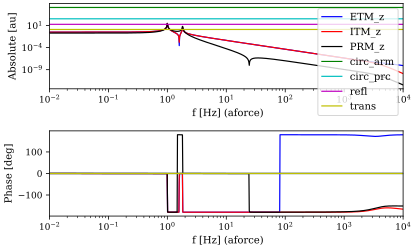

In [5]:
kat_tf = kat1.deepcopy()
kat_tf.parse("""

tf sus1 1 0 p 1 3000
attr PRM mass 0.03 zmech sus1
attr ITM mass 0.03 zmech sus1
attr ETM mass 0.03 zmech sus1


fsig aforce ETM Fz 1 0 1
xd PRM_z PRM z
xd ITM_z ITM z
xd ETM_z ETM z




pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6

xaxis aforce f log 0.01 10k 1000
yaxis log abs:deg


""")


out_df = kat_tf.run()
out_df.info()
out_df.plot()


In [6]:

print(abs(out_df['PRM_z']))

[1.96529682e-01 1.96530400e-01 1.96531134e-01 ... 3.95669550e-13
 3.65148716e-13 3.36959782e-13]


In [7]:
print(np.angle(out_df['PRM_z']))

[-4.34490446e-06 -4.39738886e-06 -4.46683706e-06 ... -2.63763787e+00
 -2.63737540e+00 -2.63705524e+00]


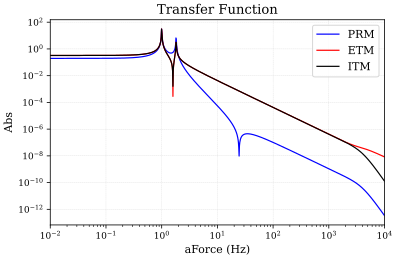

In [8]:
plt.plot(out_df.x, abs(out_df['PRM_z']),label='PRM')
plt.plot(out_df.x, abs(out_df['ETM_z']),label='ETM')
plt.plot(out_df.x, abs(out_df['ITM_z']),label='ITM')
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Function")
plt.xlabel("aForce (Hz)")
plt.ylabel("Abs")
plt.legend()

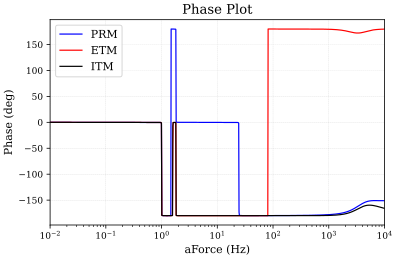

In [9]:
plt.plot(out_df.x, np.angle(out_df['PRM_z'],deg=True),label='PRM')
plt.plot(out_df.x, np.angle(out_df['ETM_z'],deg=True),label='ETM')
plt.plot(out_df.x, np.angle(out_df['ITM_z'],deg=True),label='ITM')
plt.xscale("log")
plt.title("Phase Plot")
plt.xlabel("aForce (Hz)")
plt.ylabel("Phase (deg)")
plt.legend()

c:\Users\Parivesh\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


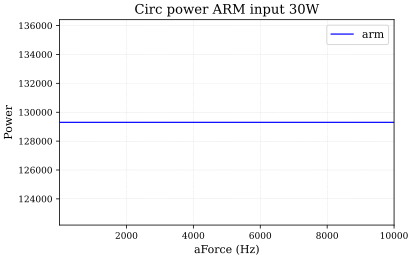

In [10]:
plt.plot(out_df.x, (out_df['circ_arm']),label='arm')
#plt.xscale("log")
plt.title("Circ power ARM input 30W")
plt.xlabel("aForce (Hz)")
plt.ylabel("Power")
plt.legend()

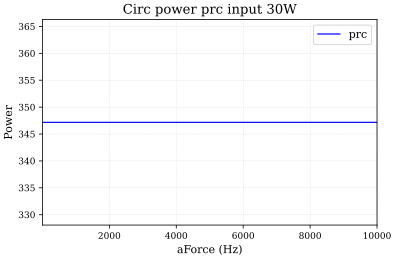

In [11]:
plt.plot(out_df.x, (out_df['circ_prc']),label='prc')
#plt.xscale("log")
plt.title("Circ power prc input 30W")
plt.xlabel("aForce (Hz)")
plt.ylabel("Power")
plt.legend()

--------------------------------------------------------------
Running kat - Started at 2022-11-27 03:33:57.545281


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 4.31653 seconds

--- Output info ---

Run date and time: 2022-11-27 03:33:57.545280
Detectors used: ETM_z, ITM_z, PRM_z, circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis aforce f log 0.1 4 800']
PRM_z Abs            : min = 0.000000000000000e+00 max = 0.000000000000000e+00
PRM_z Phase [Deg]    : min = 0.000000000000000e+00 max = 0.000000000000000e+00
ITM_z Abs            : min = 3.557390161908880e-03 max = 7.239241662671340e+02
ITM_z Phase [Deg]    : min = -1.799899963942590e+02 max = 1.799931052005130e+02
ETM_z Abs            : min = 6.062074308160530e-02 max = 8.353977171639960e+02
ETM_z Phase [Deg]    : min = -1.799950115504840e+02 max = -4.372944528391350e-03
circ_arm Abs         : min = 1.722267393605870e+06 max = 1.722267393605870e+06
circ_arm Phase [Deg] : min = 0.000000000000000e+00 max = 0.000000000000000e+00
circ_prc Abs         : min = 4.508806688798960e+03 max = 4.508806688798960e+03
c

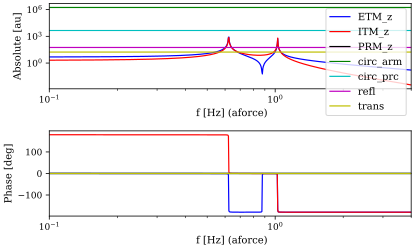

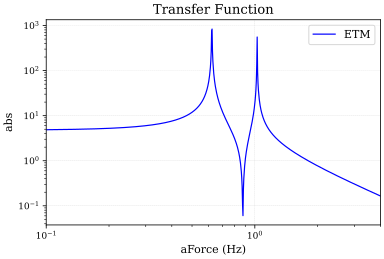

In [12]:
kat1.ETM.phi = 0
kat1.laser.P = 200
kat_tf1 = kat1.deepcopy()
kat_tf1.parse("""
tf sus1 1 0 p 1 3000

#attr PRM Ix 0.01 rxmech sus1
attr ITM Ix 0.01 rxmech sus1
attr ETM Ix 0.01 rxmech sus1

fsig aforce ETM Frx 1 0 1

xd PRM_z PRM rx
xd ITM_z ITM rx
xd ETM_z ETM rx

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6

xaxis aforce f log 0.1 0.004k 800
yaxis log abs:deg
""")

out_df1 = kat_tf1.run()
out_df1.info()
out_df1.plot()
#plt.plot(out_df1.x, abs(out_df1['PRM_z']),label='PRM')
plt.plot(out_df1.x,abs(out_df1['ETM_z']),label='ETM')
#plt.plot(out_df1.x, abs(out_df1['ITM_z']),label='ITM')
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Function")
plt.xlabel("aForce (Hz)")
plt.ylabel("abs")
plt.legend()
#print(abs(out_df1['ETM_z']))



[0.62376682 0.87743069 1.02636154]
[0.87743069]
[0.62376682 1.02636154]


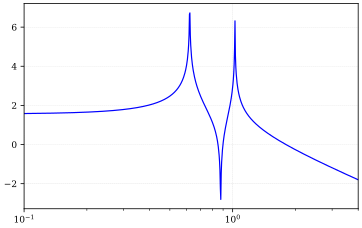

In [13]:
a = np.diff(np.sign(np.diff( np.log(out_df1['ETM_z'])))).nonzero()[0] + 1               # local min & max
b = (np.diff(np.sign(np.diff(np.log(out_df1['ETM_z'])))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(np.log(out_df1['ETM_z'])))) < 0).nonzero()[0] + 1

print(np.real(out_df1.x[a]))
print(np.real(out_df1.x[b]))
print(np.real(out_df1.x[c]))

plt.plot(out_df1.x, np.log(out_df1['ETM_z']),label='ETM')
plt.xscale("log")
#plt.yscale("log")
#plt.axvloge(x=out_df1.x[c][0])
#plt.axvloge(x=out_df1.x[c][1])
#
#plt.axvloge(x=out_df1.x[b][0])
#plt.axvloge(x=out_df1.x[b][1])



In [14]:
w0 = 10*np.pi
L = 3.3
I = 0.000047
c = 3*1e8
g1 = 0.708
g2 = 1

x = np.linspace(0, 0.07*1e7, 100000)

y_1 = ((w0**2) + ((x*L)/(I*c))*(-(g1+g2)+(4+(g1-g2)**2)**0.5)/(1-g1*g2))**0.5

y_2 = np.real(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))
y_21 = -1*np.imag(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))

y_3 = np.real(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))
y_31 = -1*np.imag(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))


y_2zero = x[np.argwhere(y_2 == 0)[0]]
y_3zero = x[np.argwhere(y_3 == 0)[0]]

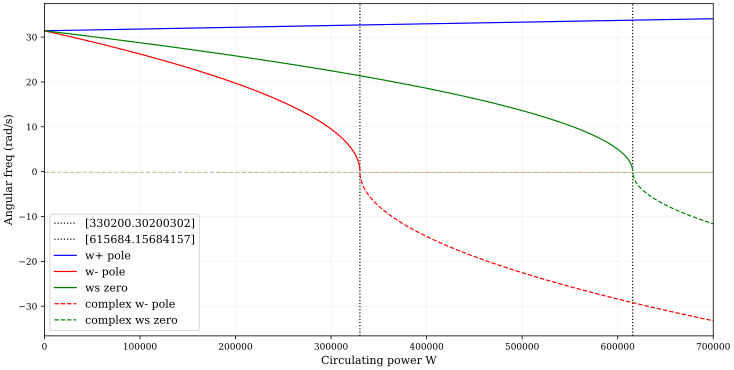

In [15]:
plt.figure(figsize=(12, 6))

plt.axvline(x=y_2zero,label = str(y_2zero),linestyle = "dotted",color = "black")
plt.axvline(x=y_3zero,label = str(y_3zero),linestyle = "dotted",color = "black") 


plt.plot(x, y_1,label="w+ pole")
plt.plot(x, y_2,color = 'red',label="w- pole")
plt.plot(x, y_3,color = 'green',label="ws zero")
plt.plot(x, y_21,color = 'red',linestyle = '--',label="complex w- pole")
plt.plot(x, y_31,color = 'green',linestyle = '--',label="complex ws zero")

plt.axhline(y=0,color="white")
plt.xlabel("Circulating power W")
plt.ylabel("Angular freq (rad/s)")
plt.legend()

--------------------------------------------------------------
Running kat - Started at 2022-11-27 03:34:07.302665


 78% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 1.24752 seconds


100% | ETA:  0:00:00 | Calculating                                             

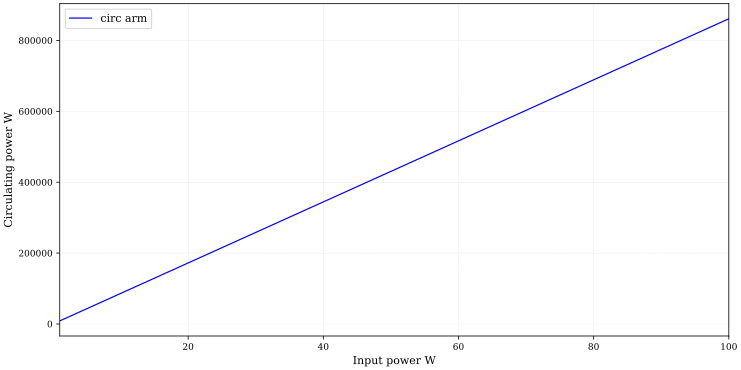

In [17]:
kat1.ETM.phi = 0
kat_tf2 = kat1.deepcopy()
kat_tf2.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis laser P lin 1 100 800

""")
plt.figure(figsize=(12, 6))
out_df2 = kat_tf2.run()
plt.plot(out_df2.x,out_df2['circ_arm'],label = "circ arm")
#plt.plot(out_df2.x,out_df2['circ_prc'],label = "circ prc")
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Input power W")
plt.ylabel("Circulating power W")
plt.legend()

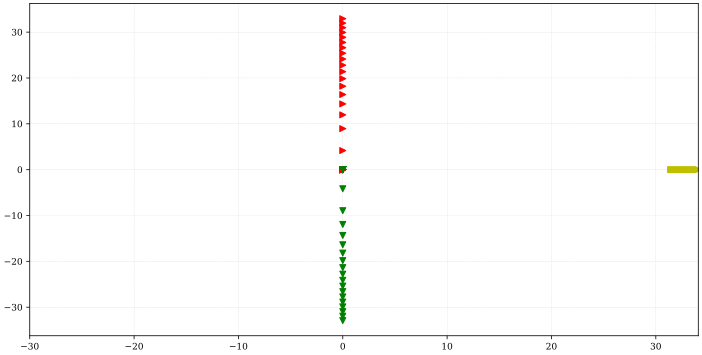

In [39]:
plt.figure(figsize=(12, 6))
i = 1
j= 1
while i in range(len(y_2)):
    plt.plot(y_1[i],0,marker=">", color='y')
    plt.plot(0,-y_21[i],marker=">", color='r')
    plt.plot(0,y_21[i],marker="v",color='g')
    #print(y_2[i])
    i = i+3000
    j = j+3000

plt.plot(-30,-30,color='white')
plt.plot(-30,30,color='white')